
# 00 — Probability Basics
*A hands-on primer with clear theory + simulations and visualizations.*

**What you'll learn**
- Random variables, **PMF/PDF/CDF**, expectation, variance.
- Canonical distributions: **Bernoulli, Binomial, Geometric, Poisson, Uniform, Normal, Exponential**.
- **Law of Large Numbers (LLN)** and **Central Limit Theorem (CLT)** via simulation.
- Joint & conditional probability, independence, covariance, correlation.
- **Bayes' rule** with an applied diagnostic-testing example.

> **How to use this notebook:** Read each *Theory* block first, then run the code cell(s) that follow to build intuition via simulation and plots.


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Plotting defaults
plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["axes.grid"] = True

# Reproducibility
rng = np.random.default_rng(42)

def ecdf(x):
    """Empirical CDF for a 1D array."""
    x = np.sort(np.asarray(x))
    n = x.size
    y = np.arange(1, n+1) / n
    return x, y

def hist_with_pdf(samples, bins=40, pdf=None, xpdf=None, title=""):
    plt.figure()
    plt.hist(samples, bins=bins, density=True, alpha=0.6)
    if pdf is not None and xpdf is not None:
        plt.plot(xpdf, pdf, linewidth=2)
    plt.title(title)
    plt.tight_layout()
    plt.show()

## 1. Random Variables & Distributions — PMF, PDF, CDF

### Intuition

A **random variable (RV)** is a numeric representation of uncertainty — a function that maps outcomes of a random process (like a dice roll, stock movement, or policy action) to numerical values.

Formally, if $\Omega$ is the **sample space** (all possible outcomes),  
a random variable $X : \Omega \to \mathbb{R}$ assigns each outcome a number.

For example:
- Rolling a fair die → $X(\omega) \in \{1,2,3,4,5,6\}$
- Measuring time to failure → $X(\omega) \in \mathbb{R}_{\ge 0}$
- The reward from a stochastic policy → $R_t = R(s_t, a_t)$


### Types of Random Variables

| Type | Domain | Representation | Key Quantity |
|------|---------|----------------|---------------|
| **Discrete** | Countable (e.g., 0, 1, 2, 3) | $X \in \mathbb{Z}$ | **PMF** — Probability Mass Function |
| **Continuous** | Uncountable (e.g., real interval) | $X \in \mathbb{R}$ | **PDF** — Probability Density Function |


### Discrete Random Variables — PMF

For a **discrete** random variable $X$,
the **probability mass function (PMF)** assigns probabilities to individual values:

$$
p_X(x) = \Pr[X = x]
$$
with
$$
\sum_{x} p_X(x) = 1.
$$

Example:  
For a fair die,
$$
p_X(x) = \frac{1}{6}, \quad x \in \{1,2,3,4,5,6\}.
$$

In **RL**, the PMF might represent:
- the probability of choosing each **discrete action** under a stochastic policy $\pi(a|s)$
- the distribution over **discrete rewards** or **terminal states**.


### Continuous Random Variables — PDF

For **continuous** random variables,
probabilities are defined over intervals via the **probability density function (PDF)**:

$$
f_X(x) \ge 0, \quad \int_{-\infty}^{\infty} f_X(x) \, dx = 1.
$$

Since single points have zero probability:
$$
\Pr[a \le X \le b] = \int_{a}^{b} f_X(x)\,dx.
$$

Example:  
If $X \sim \mathcal{N}(0,1)$, then

$$
f_X(x) = \frac{1}{\sqrt{2\pi}} e^{-x^2/2}.
$$

In **RL**, PDFs appear when:
- policies are **continuous** (e.g., Gaussian policy $\pi(a|s) = \mathcal{N}(\mu(s), \sigma^2(s))$)
- environments have **continuous state or action spaces**


### Cumulative Distribution Function — CDF

The **cumulative distribution function (CDF)** gives cumulative probability up to a point:

$$
F_X(t) = \Pr[X \le t].
$$

For discrete RVs:
$$
F_X(t) = \sum_{x \le t} p_X(x),
$$
and for continuous ones:
$$
F_X(t) = \int_{-\infty}^{t} f_X(x)\,dx.
$$

The CDF is always non-decreasing, with  
$F_X(-\infty)=0$ and $F_X(\infty)=1$.  
If $X$ is continuous and differentiable, $f_X(x) = \frac{d}{dx}F_X(x)$.

In **RL**, the CDF helps when:
- computing **value-at-risk (VaR)** or **quantile-based objectives** (used in **distributional RL** like C51 or QR-DQN)
- analyzing **return distributions** instead of just expectations


### RL Connection

| RL Concept | Random Variable Analogy |
|-------------|------------------------|
| Reward $R_t$ | Sample from a stochastic reward distribution |
| Return $G_t = \sum \gamma^k R_{t+k}$ | Sum of dependent random variables |
| Policy $\pi(a|s)$ | PMF/PDF over actions |
| Exploration noise | Continuous distribution (e.g., Gaussian) added to deterministic policy |
| Distributional RL | Models the full return **CDF**, not just the mean value function |

Understanding PMFs, PDFs, and CDFs lays the foundation for **policy learning**, **return estimation**, and **probabilistic reasoning** in reinforcement learning.

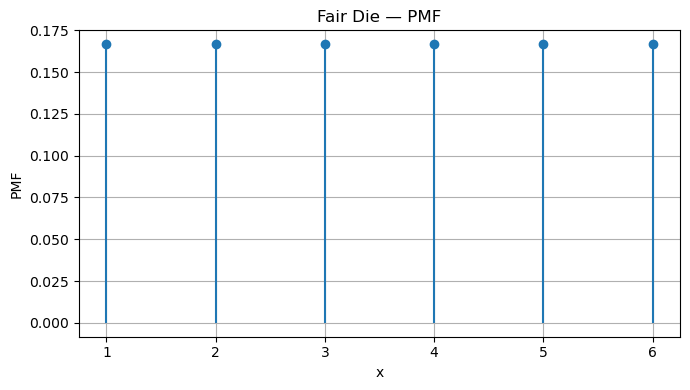

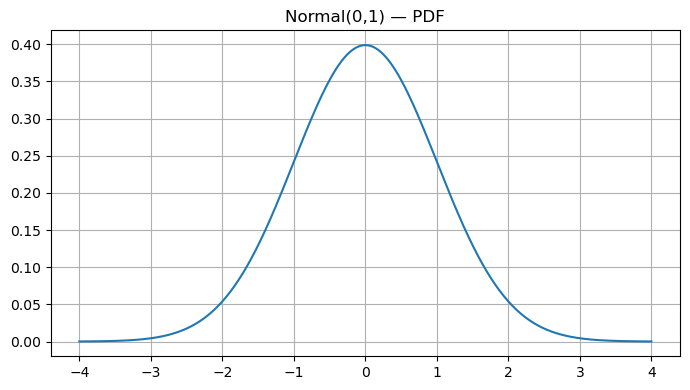

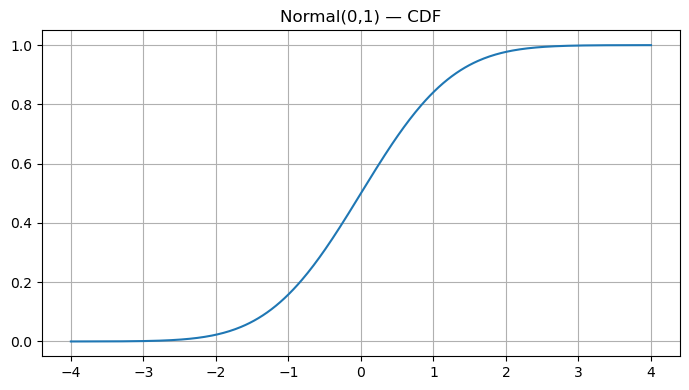

In [2]:
# Discrete example: PMF of a fair die
vals = np.arange(1, 7)
pmf = np.full_like(vals, 1/6, dtype=float)

plt.figure()
plt.stem(vals, pmf, basefmt=" ", markerfmt="o", linefmt="-")
plt.xlabel("x")
plt.ylabel("PMF")
plt.title("Fair Die — PMF")
plt.tight_layout()
plt.show()

# Continuous example: PDF & CDF of Normal(0,1)
from math import erf

def norm_pdf(x, mu=0.0, sigma=1.0):
    return (1.0 / (sigma * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def norm_cdf(x, mu=0.0, sigma=1.0):
    from scipy.special import erf
    z = (x - mu) / (sigma * math.sqrt(2))
    return 0.5 * (1 + erf(z))

x = np.linspace(-4, 4, 400)

plt.figure()
plt.plot(x, norm_pdf(x))
plt.title("Normal(0,1) — PDF")
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(x, norm_cdf(x))
plt.title("Normal(0,1) — CDF")
plt.tight_layout()
plt.show()

## 2. Expectation & Variance

### Intuition

The **expectation** (or **expected value**) and **variance** are the two most fundamental numerical summaries of a random variable.  
They describe:
- **Expectation** → the *average* or *central tendency* of the distribution.
- **Variance** → how *spread out* or *uncertain* the outcomes are around that average.

In reinforcement learning (RL), these concepts directly underlie:
- **Expected return** (what we maximize)
- **Reward variance** (which affects stability and exploration)
- **Policy gradient variance** (a key challenge in training)


### Expectation — “the long-run average”

The **expectation** of a random variable $X$ represents the *average value* we would obtain if we repeated the random process infinitely many times.

For a **discrete** random variable:
$$
\mathbb{E}[X] = \sum_x x \, p(x)
$$

For a **continuous** random variable:
$$
\mathbb{E}[X] = \int_{-\infty}^{\infty} x \, f(x)\, dx
$$

> Think of expectation as a “weighted average,” where each possible value of $X$ is weighted by its probability of occurring.

**Example (Bernoulli $p$):**  
For $ X \in \{0, 1\} $ with $ \Pr[X=1]=p $,
$$
\mathbb{E}[X] = 0 \cdot (1-p) + 1 \cdot p = p
$$

So the expected number of successes in one Bernoulli trial equals the probability of success itself.


### Variance — “measuring uncertainty”

The **variance** measures how far outcomes tend to deviate from their mean.  
It is defined as:

$$
\mathrm{Var}(X) = \mathbb{E}\big[(X - \mu)^2\big] = \mathbb{E}[X^2] - (\mathbb{E}[X])^2
$$

where $ \mu = \mathbb{E}[X] $.

The **standard deviation** is simply the square root of the variance:
$$
\sigma_X = \sqrt{\mathrm{Var}(X)}.
$$

A **larger variance** means outcomes are more unpredictable — critical in RL, where high variance in returns or gradients can destabilize learning.

**Example (Bernoulli $p$):**
$$
\mathrm{Var}(X) = p(1 - p)
$$

When $p = 0.5$, uncertainty is highest (max variance); when $p$ is near 0 or 1, variance is small — outcomes are predictable.


### Linearity of Expectation

A beautiful property: **expectation is always linear**, even if random variables are dependent.

For constants $a,b$:
$$
\mathbb{E}[aX + b] = a\,\mathbb{E}[X] + b
$$

and for multiple random variables:
$$
\mathbb{E}\Big[\sum_i X_i\Big] = \sum_i \mathbb{E}[X_i]
$$

This property is used throughout RL, for example when analyzing expected returns or when computing value functions from reward sequences.


### RL Connections

| Concept | Description | Mathematical Tie-In |
|----------|--------------|--------------------|
| **Expected Return** | RL agents aim to maximize expected cumulative reward. | $ J(\pi) = \mathbb{E}_{\pi}\big[\sum_{t=0}^{\infty} \gamma^t R_t\big] $ |
| **Policy Gradient** | Gradients of expected return rely on linearity of expectation. | $ \nabla_\theta J(\pi_\theta) = \mathbb{E}_\pi[\nabla_\theta \log \pi_\theta(a\|s) G_t] $ |
| **Variance Reduction** | High gradient variance slows learning; techniques like baselines, advantage functions, and entropy regularization reduce it. | $ \mathrm{Var}[G_t] \downarrow \Rightarrow \text{more stable updates} $ |
| **Risk-Sensitive RL** | Some tasks care not only about the mean but also about variability in rewards. | Optimize $ \mathbb{E}[G_t] - \lambda \mathrm{Var}[G_t] $ |

{'est_mean': np.float64(0.3023), 'theory_mean': 0.3}
{'est_var': np.float64(0.2109), 'theory_var': 0.21}


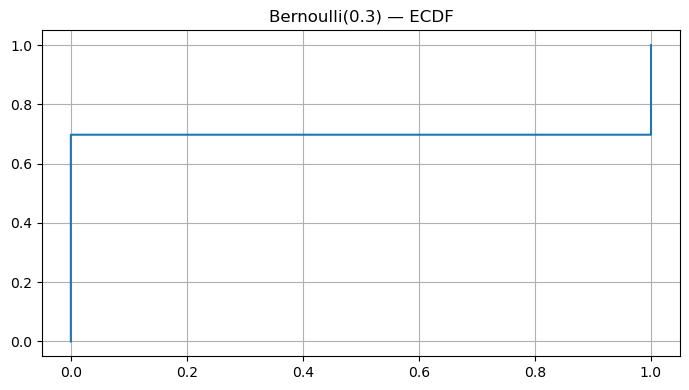

In [3]:
p = 0.3
samples = rng.binomial(n=1, p=p, size=50_000)
est_mean, est_var = samples.mean(), samples.var(ddof=0)
theory_mean, theory_var = p, p*(1-p)
print({"est_mean": round(est_mean,4), "theory_mean": theory_mean})
print({"est_var": round(est_var,4), "theory_var": theory_var})

# ECDF of Bernoulli
x_ecdf, y_ecdf = ecdf(samples)
plt.figure()
plt.step(x_ecdf, y_ecdf, where='post')
plt.title("Bernoulli(0.3) — ECDF")
plt.tight_layout(); plt.show()

## 3. Canonical Distributions

Probability distributions describe **how uncertainty is structured** — how likely different outcomes are.  
In Reinforcement Learning (RL), nearly every component (rewards, actions, transitions) involves random variables.  
Understanding these *canonical* distributions gives the mathematical foundation for modeling, exploration, and inference.


### 1. Bernoulli Distribution — “One Shot, Two Outcomes”

Represents a **single binary event** — success (1) or failure (0).

$$
X \sim \text{Bernoulli}(p), \quad p_X(x) = 
\begin{cases}
p & x = 1 \\
1-p & x = 0
\end{cases}
$$

**Expectation:** $\mathbb{E}[X] = p$  
**Variance:** $\mathrm{Var}(X) = p(1-p)$

**RL Connection:**  
- Represents **stochastic binary actions** (e.g., “jump” vs “don’t jump”).  
- Used in **ε-greedy exploration**: pick a random action with prob. $\varepsilon$.  
- Models **binary rewards** (win/loss, success/failure).


### 2. Binomial Distribution — “Many Independent Bernoulli Trials”

Represents the **number of successes** in $n$ independent Bernoulli trials.

$$
X \sim \text{Binomial}(n,p), \quad p_X(k) = \binom{n}{k} p^k (1-p)^{n-k}
$$

**Expectation:** $\mathbb{E}[X] = np$  
**Variance:** $\mathrm{Var}(X) = np(1-p)$

**RL Connection:**  
- Used to model **success counts** during episodes or rollouts (e.g., number of wins).  
- Appears when evaluating **Monte Carlo estimates** over multiple trials.  


### 3. Geometric Distribution — “How Long Until Success?”

Represents the **number of trials** until the first success.

$$
X \sim \text{Geometric}(p), \quad p_X(k) = (1-p)^{k-1}p, \quad k = 1,2,\dots
$$

**Expectation:** $\mathbb{E}[X] = \frac{1}{p}$  
**Variance:** $\mathrm{Var}(X) = \frac{1-p}{p^2}$

**RL Connection:**  
- Models **waiting time for a successful episode or goal**.  
- The **memoryless property** reflects many RL processes where only the current state matters — no dependence on the past.


### 4. Poisson Distribution — “Counting Rare Events”

Represents the **number of events** occurring in a fixed time or space interval.

$$
X \sim \text{Poisson}(\lambda), \quad p_X(k) = e^{-\lambda} \frac{\lambda^k}{k!}, \quad k=0,1,2,\dots
$$

**Expectation:** $\mathbb{E}[X] = \lambda$  
**Variance:** $\mathrm{Var}(X) = \lambda$

**RL Connection:**  
- Models **event arrivals** (e.g., rare rewards or resets).  
- Useful in **environment modeling** where transitions or rewards are **asynchronous** or **stochastic in time**.


### 5. Uniform Distribution — “All Outcomes Equally Likely”

Every outcome in an interval $[a,b]$ has equal probability.

$$
X \sim \text{Uniform}[a,b], \quad f_X(x) = 
\begin{cases}
\frac{1}{b-a}, & a \le x \le b \\
0, & \text{otherwise}
\end{cases}
$$

**Expectation:** $\mathbb{E}[X] = \frac{a+b}{2}$  
**Variance:** $\mathrm{Var}(X) = \frac{(b-a)^2}{12}$

**RL Connection:**  
- Common for **random initialization** of parameters, actions, or states.  
- Uniform exploration (before learning begins).  


### 6. Normal (Gaussian) Distribution — “Central Limit Behavior”

Describes many natural random processes due to the **Central Limit Theorem (CLT)**.

$$
X \sim \mathcal{N}(\mu, \sigma^2), \quad f_X(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\!\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)
$$

**Expectation:** $\mathbb{E}[X] = \mu$  
**Variance:** $\mathrm{Var}(X) = \sigma^2$

**RL Connection:**  
- Fundamental in **Gaussian policies** for **continuous action spaces**.  
- Used in **policy gradient methods** (e.g., PPO, DDPG) to model $\pi(a|s) = \mathcal{N}(\mu_\theta(s), \sigma^2_\theta(s))$.  
- Appears in **noise processes** for exploration (Ornstein–Uhlenbeck, Gaussian).


### 7. Exponential Distribution — “Waiting Time Between Poisson Events”

Represents the **time between events** in a Poisson process.

$$
X \sim \text{Exponential}(\lambda), \quad f_X(x) = \lambda e^{-\lambda x}, \quad x \ge 0
$$

**Expectation:** $\mathbb{E}[X] = \frac{1}{\lambda}$  
**Variance:** $\mathrm{Var}(X) = \frac{1}{\lambda^2}$

**RL Connection:**  
- Models **waiting time until next event/reward**.  
- Appears in **continuous-time RL** or **semi-Markov decision processes (SMDPs)**, where actions have variable durations.

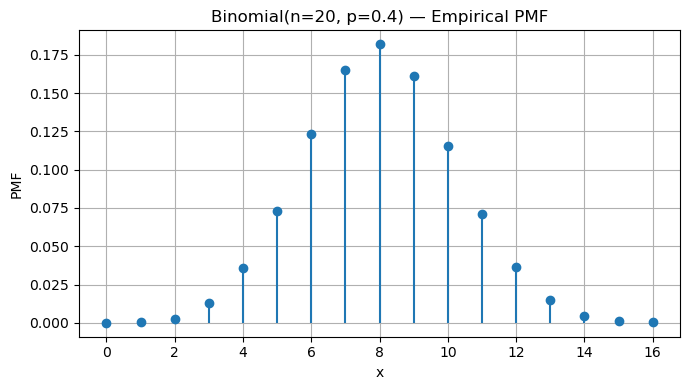

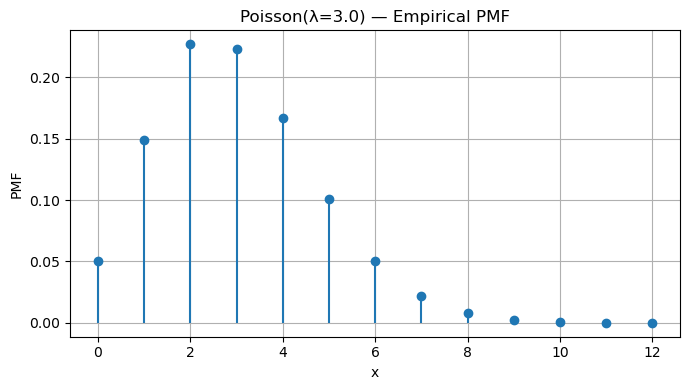

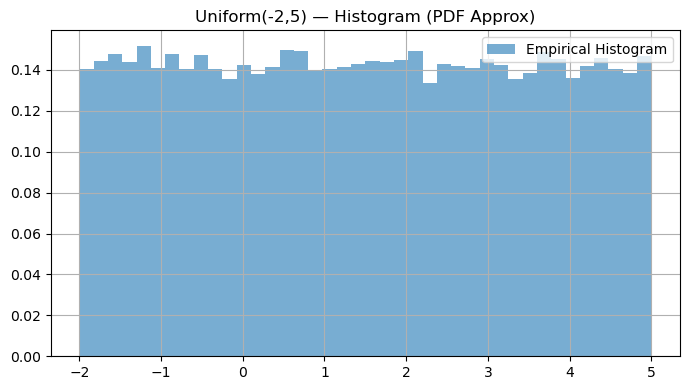

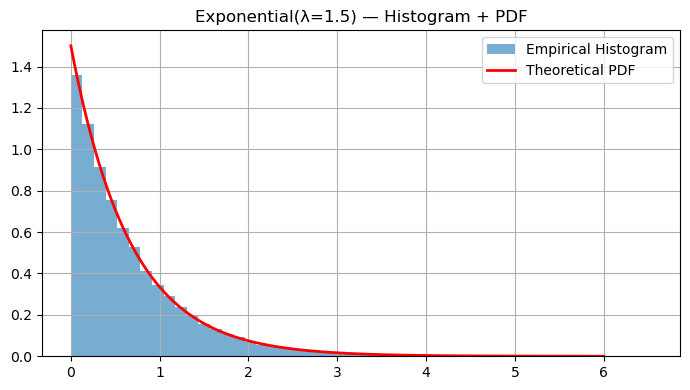

In [4]:
# Binomial(n,p): empirical PMF
n, p = 20, 0.4
binom_samples = rng.binomial(n=n, p=p, size=50_000)
counts = Counter(binom_samples)
xs = np.array(sorted(counts.keys()))
ys = np.array([counts[k] for k in xs]) / len(binom_samples)

plt.figure()
plt.stem(xs, ys, basefmt=" ", markerfmt="o", linefmt="-")
plt.xlabel("x")
plt.ylabel("PMF")
plt.title(f"Binomial(n={n}, p={p}) — Empirical PMF")
plt.tight_layout()
plt.show()

# Poisson(lambda): empirical PMF
lam = 3.0
pois = rng.poisson(lam=lam, size=50_000)
counts = Counter(pois)
xs = np.array(sorted(counts.keys()))
ys = np.array([counts[k] for k in xs]) / len(pois)

plt.figure()
plt.stem(xs, ys, basefmt=" ", markerfmt="o", linefmt="-")
plt.xlabel("x")
plt.ylabel("PMF")
plt.title(f"Poisson(λ={lam}) — Empirical PMF")
plt.tight_layout()
plt.show()

# Uniform(a,b) and Exponential(lambda)
def hist_with_pdf(samples, bins=50, pdf=None, xpdf=None, title=None):
    plt.figure()
    plt.hist(samples, bins=bins, density=True, alpha=0.6, label="Empirical Histogram")
    if pdf is not None and xpdf is not None:
        plt.plot(xpdf, pdf, "r-", lw=2, label="Theoretical PDF")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Uniform
a, b = -2, 5
U = rng.uniform(a, b, size=50_000)
hist_with_pdf(U, bins=40, title="Uniform(-2,5) — Histogram (PDF Approx)")

# Exponential
lam = 1.5
Exp = rng.exponential(1/lam, size=50_000)
xpdf = np.linspace(0, 6, 400)
exp_pdf = lam * np.exp(-lam * xpdf)
hist_with_pdf(Exp, bins=50, pdf=exp_pdf, xpdf=xpdf, title="Exponential(λ=1.5) — Histogram + PDF")

## 4. Law of Large Numbers (LLN)

The **Law of Large Numbers (LLN)** is one of the cornerstones of probability theory — and it directly connects to how reinforcement learning (RL) agents estimate returns and values from experience.


### Intuition

Suppose we repeat a random experiment many times, each time obtaining an outcome $X_i$.
The **sample mean** after $n$ trials is:

$$
\bar{X}_n = \frac{1}{n}\sum_{i=1}^n X_i
$$

The **Law of Large Numbers** states that as the number of samples grows,
the sample mean converges to the *true expected value* $\mu = \mathbb{E}[X]$:

$$
\lim_{n \to \infty} \bar{X}_n = \mu
$$

Formally, in probability (weak LLN):

$$
\forall \varepsilon > 0, \quad
\Pr\big(|\bar{X}_n - \mu| > \varepsilon\big) \to 0 \text{ as } n \to \infty.
$$

If convergence happens *almost surely* (with probability 1), we have the **strong LLN**.


### Intuitive Example

If you flip a fair coin repeatedly, the true mean (probability of heads) is $\mu = 0.5$.

- After 10 flips, your sample mean might be 0.4 or 0.7.
- After 1000 flips, it will almost surely be close to 0.5.

As $n$ increases, the sample mean becomes **more stable and less noisy**, illustrating that randomness “averages out” in the long run.


### Mathematical Insight

The variance of the sample mean decreases with $n$:

$$
\mathrm{Var}[\bar{X}_n] = \frac{\sigma^2}{n},
$$

so the spread of sample means around the true mean $\mu$ gets smaller as you collect more data.

This property underlies **statistical consistency** — empirical estimates become accurate as data accumulates.


### RL Connection

The Law of Large Numbers explains *why experience-based learning works* in reinforcement learning.

| RL Concept | LLN Interpretation |
|-------------|-------------------|
| **Monte Carlo value estimation** | Averaging many episode returns $G_t$ approximates $ V(s) = \mathbb{E}_\pi[G_t \| s_t = s] $. |
| **Q-learning targets** | The empirical mean of temporal-difference (TD) targets converges to the true expected value. |
| **Policy gradient estimates** | Gradient estimates improve as you average over many sampled trajectories. |
| **Exploration and variance** | More data reduces stochasticity in policy/value updates, leading to stable learning. |

Essentially, **RL algorithms rely on LLN** to justify learning from finite samples:  
> as the number of episodes → ∞, empirical estimates converge to their theoretical expectations.

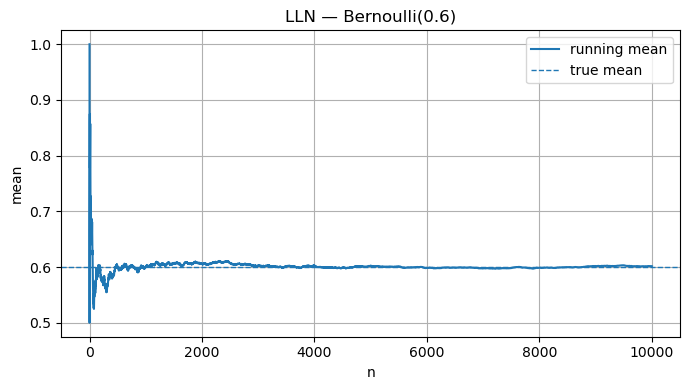

In [5]:
p = 0.6
N = 10_000
bern = rng.binomial(1, p, size=N)
running_mean = np.cumsum(bern) / (np.arange(N) + 1)

plt.figure()
plt.plot(running_mean, label="running mean")
plt.axhline(p, linestyle='--', linewidth=1, label="true mean")
plt.xlabel("n"); plt.ylabel("mean"); plt.title("LLN — Bernoulli(0.6)")
plt.legend(); plt.tight_layout(); plt.show()

## 5. Central Limit Theorem (CLT)

The **Central Limit Theorem (CLT)** is one of the most powerful ideas in probability and statistics.  
It tells us that *averages of random variables tend to follow a Normal (Gaussian) distribution*, no matter what the underlying distribution is — provided we have enough independent samples.


### Intuition

Let $X_1, X_2, \dots, X_n$ be **independent and identically distributed (IID)** random variables, each with:
- Mean $\mu = \mathbb{E}[X_i]$
- Variance $\sigma^2 = \mathrm{Var}(X_i) < \infty$

Then, the **standardized sample mean**

$$
Z_n = \frac{\bar{X}_n - \mu}{\sigma / \sqrt{n}}
$$

**converges in distribution** to the standard normal:

$$
Z_n \xrightarrow{d} \mathcal{N}(0,1) \quad \text{as } n \to \infty.
$$

In words:
> Even if the original data $X_i$ are not normally distributed (e.g., exponential, uniform, or Bernoulli),
> the distribution of their average $\bar{X}_n$ becomes approximately normal for large $n$.


### Why It Matters

This theorem explains **why the Normal distribution is everywhere** — it emerges naturally as the limit of sums or averages of random variables.

The larger the number of samples $n$, the closer the sample mean’s distribution looks to a bell curve, regardless of the parent distribution.

Mathematically:

$$
\Pr\left( \frac{\bar{X}_n - \mu}{\sigma/\sqrt{n}} \le z \right) \approx \Phi(z),
$$
where $\Phi(z)$ is the CDF of $\mathcal{N}(0,1)$.


### RL Connection

The CLT provides the **theoretical foundation for stability** in reinforcement learning:

| RL Concept | CLT Interpretation |
|-------------|-------------------|
| **Monte Carlo return estimates** | Averages of episode returns approximate a Normal distribution as sample count increases. |
| **Policy gradient estimation** | The stochastic gradient noise becomes approximately Gaussian — enabling the use of variance reduction and adaptive learning-rate methods. |
| **Bootstrapping and TD updates** | Aggregated target errors tend toward Gaussianity, improving predictability of learning dynamics. |
| **Confidence intervals for evaluation** | Approximate Normality allows for error bars and uncertainty quantification of value estimates. |

In short:
> The CLT justifies why *empirical averages in RL* can be treated as *normally distributed noise* — enabling efficient optimization, statistical inference, and uncertainty modeling.

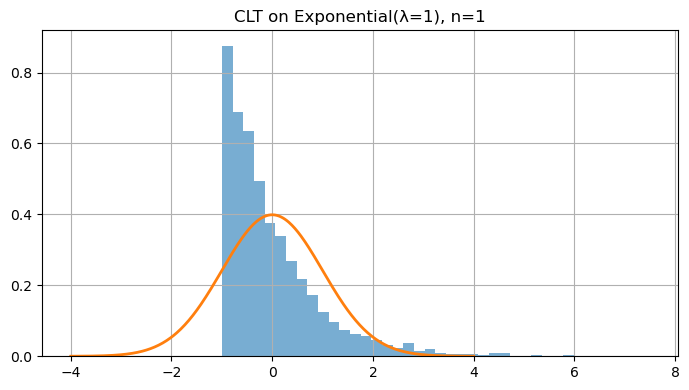

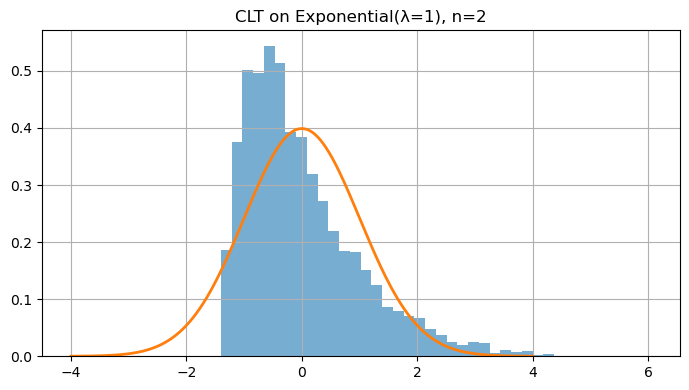

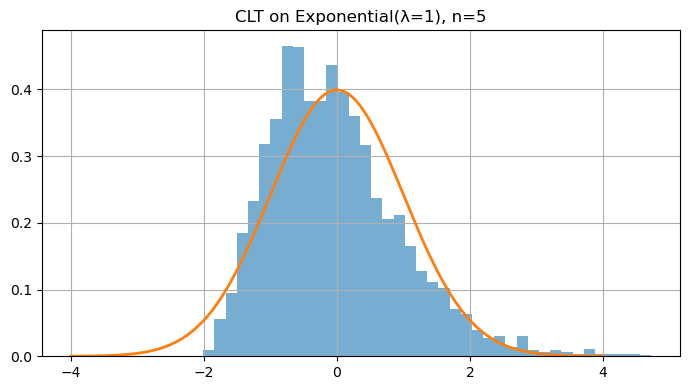

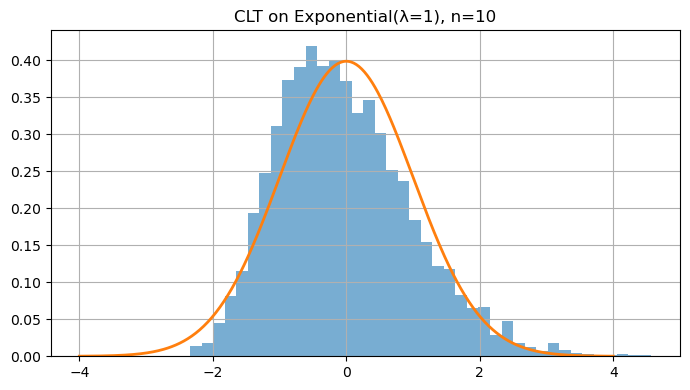

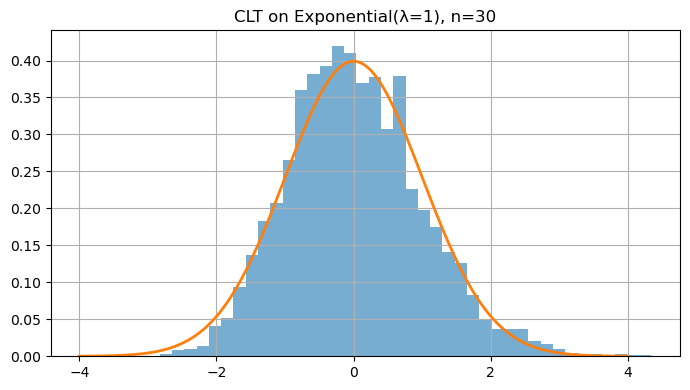

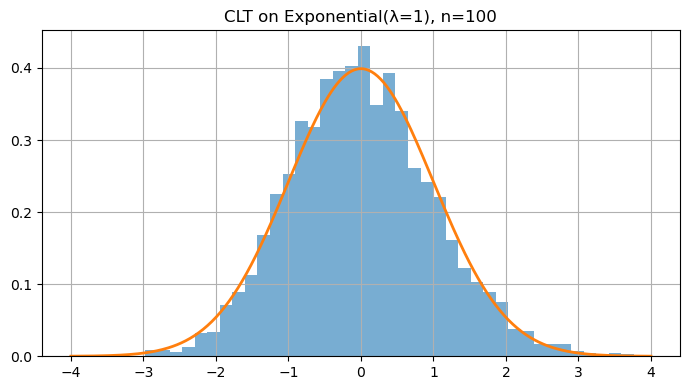

In [6]:
def clt_demo(dist_sampler, n, trials=4000):
    means = []
    for _ in range(trials):
        x = dist_sampler(n)
        means.append(np.mean(x))
    return np.array(means)

# Skewed distribution: Exponential(λ=1)
lam = 1.0
def samp_exp(n): return rng.exponential(1/lam, size=n)

for n in [1, 2, 5, 10, 30, 100]:
    means = clt_demo(samp_exp, n=n, trials=4000)
    mu, var = 1/lam, 1/(lam**2)
    z = (means - mu) / math.sqrt(var/n)  # standardize
    plt.figure()
    plt.hist(z, bins=40, density=True, alpha=0.6)
    x = np.linspace(-4, 4, 400)
    plt.plot(x, (1/np.sqrt(2*np.pi))*np.exp(-x**2/2), linewidth=2)
    plt.title(f"CLT on Exponential(λ=1), n={n}")
    plt.tight_layout(); plt.show()

## 6. Joint & Conditional Probability; Independence; Covariance & Correlation

Reinforcement learning operates in **stochastic environments** — where states, actions, and rewards are random variables.  
Understanding **joint**, **conditional**, and **marginal** probabilities is therefore essential for reasoning about uncertainty and dependencies between variables.


### Joint & Marginal Distributions

When we have two random variables $X$ and $Y$, their **joint distribution** describes the probability of both occurring together:

$$
p_{X,Y}(x,y) = \Pr[X = x, Y = y]
$$

For continuous variables, we write the **joint PDF** $f_{X,Y}(x,y)$.

From the joint distribution, we can derive the **marginal** distributions:

$$
p_X(x) = \sum_y p_{X,Y}(x,y),
\quad
p_Y(y) = \sum_x p_{X,Y}(x,y)
$$

or, in the continuous case,

$$
f_X(x) = \int_{-\infty}^\infty f_{X,Y}(x,y)\,dy.
$$


### Conditional Probability

The **conditional probability** of $Y$ given $X = x$ is:

$$
p_{Y|X}(y|x) = \frac{p_{X,Y}(x,y)}{p_X(x)}.
$$

It represents how knowing $X$ changes our belief about $Y$.

For continuous variables, the same relationship holds with PDFs:

$$
f_{Y|X}(y|x) = \frac{f_{X,Y}(x,y)}{f_X(x)}.
$$


### Independence

Two random variables $X$ and $Y$ are **independent** if knowledge of one gives no information about the other:

$$
X \perp Y \quad \Longleftrightarrow \quad p_{X,Y}(x,y) = p_X(x)p_Y(y)
$$

or equivalently, $p_{Y|X}(y|x) = p_Y(y)$.

This idea of independence is central to simplifying models — in RL, we often *assume* independence between samples (episodes, transitions) to enable tractable learning.


### Covariance & Correlation

**Covariance** measures how two random variables vary together:

$$
\mathrm{Cov}(X,Y) = \mathbb{E}[(X - \mu_X)(Y - \mu_Y)].
$$

If $X$ and $Y$ increase together, covariance is positive; if one increases while the other decreases, it’s negative.

However, covariance depends on scale.  
The **correlation coefficient** $\rho(X,Y)$ standardizes it:

$$
\rho(X,Y) = \frac{\mathrm{Cov}(X,Y)}{\sigma_X \sigma_Y}, \quad \rho \in [-1, 1].
$$

- $\rho = 1$: perfectly positively correlated  
- $\rho = -1$: perfectly negatively correlated  
- $\rho = 0$: uncorrelated (not necessarily independent)


### RL Connection

Joint and conditional probability form the **mathematical backbone of RL**:

| RL Concept | Probabilistic View |
|-------------|-------------------|
| **Environment dynamics** | $p(s_{t+1}, r_t \| s_t, a_t)$: joint distribution of next state and reward |
| **Transition model** | Marginal over rewards: $p(s_{t+1}\|s_t, a_t) = \sum_{r_t} p(s_{t+1}, r_t\|s_t, a_t)$ |
| **Policy stochasticity** | $\pi(a\|s) = p(A_t = a \| S_t = s)$: a conditional distribution over actions |
| **Credit assignment** | Correlation between actions $A_t$ and future returns $G_t$ drives policy improvement |
| **Exploration–exploitation trade-off** | Managing dependence between visited states and action probabilities |

These concepts explain **why RL is probabilistic at its core** — from policy sampling to estimating expected returns.

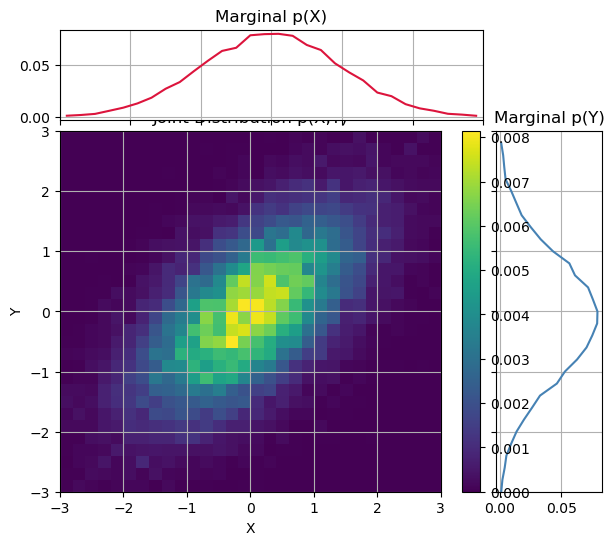

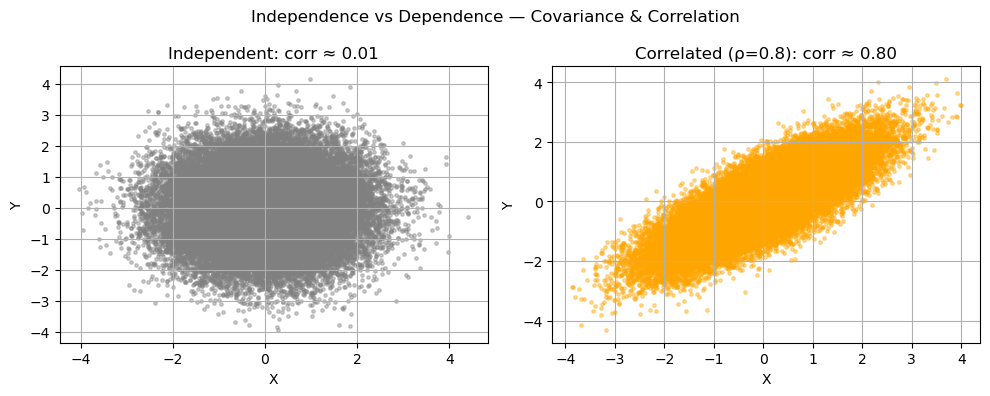

In [7]:
# Joint, Marginal, and Conditional Probability Example
rng = np.random.default_rng(0)

# Bivariate Normal with correlation ρ = 0.6
rho = 0.6
cov = np.array([[1.0, rho], [rho, 1.0]])
XY = rng.multivariate_normal([0, 0], cov, size=20_000)
X, Y = XY[:, 0], XY[:, 1]

# Empirical joint distribution via 2D histogram
nbins = 30
x_edges = np.linspace(-3, 3, nbins + 1)
y_edges = np.linspace(-3, 3, nbins + 1)
H, _, _ = np.histogram2d(X, Y, bins=[x_edges, y_edges])
H /= H.sum()  # normalize → joint pmf/pdf estimate

# Marginals
pX = H.sum(axis=1, keepdims=True)
pY = H.sum(axis=0, keepdims=True)

# Conditional p(Y|X) for one X-bin (≈ x=1)
x_centers = 0.5 * (x_edges[1:] + x_edges[:-1])
ix = np.argmin(np.abs(x_centers - 1.0))
cond = H[ix, :] / (pX[ix, 0] + 1e-12)

# --- Joint and Marginals ---
fig = plt.figure(figsize=(7, 6))
gs = fig.add_gridspec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],
                      wspace=0.05, hspace=0.05)

ax_joint = fig.add_subplot(gs[1, 0])
ax_marg_x = fig.add_subplot(gs[0, 0], sharex=ax_joint)
ax_marg_y = fig.add_subplot(gs[1, 1], sharey=ax_joint)

# Joint (2D heatmap)
im = ax_joint.imshow(H.T, origin='lower',
                     extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
                     aspect='auto', cmap='viridis')
ax_joint.set_xlabel("X"); ax_joint.set_ylabel("Y")
ax_joint.set_title("Joint Distribution p(X,Y)")
fig.colorbar(im, ax=ax_joint, orientation='vertical', fraction=0.05)

# Marginals
ax_marg_x.plot(x_centers, pX, color='crimson')
ax_marg_x.set_title("Marginal p(X)")
ax_marg_y.plot(pY.ravel(), y_edges[:-1], color='steelblue')
ax_marg_y.set_title("Marginal p(Y)")
ax_marg_x.tick_params(axis="x", labelbottom=False)
ax_marg_y.tick_params(axis="y", labelleft=False)
plt.show()

# Independence vs Dependence + Covariance/Correlation
rng = np.random.default_rng(1)

# (a) Independent variables
X_ind = rng.normal(size=50_000)
Y_ind = rng.normal(size=50_000)
cov_ind  = np.cov(X_ind, Y_ind, ddof=0)[0, 1]
corr_ind = np.corrcoef(X_ind, Y_ind)[0, 1]

# (b) Correlated variables (ρ ≈ 0.8)
rho = 0.8
cov = np.array([[1.0, rho], [rho, 1.0]])
XY = rng.multivariate_normal([0, 0], cov, size=50_000)
X_dep, Y_dep = XY[:, 0], XY[:, 1]
cov_dep  = np.cov(X_dep, Y_dep, ddof=0)[0, 1]
corr_dep = np.corrcoef(X_dep, Y_dep)[0, 1]

# --- Visualization 3: Scatter comparison ---
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].scatter(X_ind, Y_ind, s=6, alpha=0.4, color='gray')
axs[0].set_title(f"Independent: corr ≈ {corr_ind:.2f}")
axs[0].set_xlabel("X"); axs[0].set_ylabel("Y")

axs[1].scatter(X_dep, Y_dep, s=6, alpha=0.4, color='orange')
axs[1].set_title(f"Correlated (ρ=0.8): corr ≈ {corr_dep:.2f}")
axs[1].set_xlabel("X"); axs[1].set_ylabel("Y")

plt.suptitle("Independence vs Dependence — Covariance & Correlation")
plt.tight_layout()
plt.show()

## 7. Bayes’ Theorem — Diagnostic Testing

### Concept

**Bayes’ rule** allows us to *reverse conditional probabilities* — updating beliefs about a cause $A$ after observing evidence $B$:

$$
\Pr(A \mid B) = \frac{\Pr(B \mid A)\Pr(A)}{\Pr(B \mid A)\Pr(A) + \Pr(B \mid \neg A)\Pr(\neg A)}.
$$

It formalizes **belief updating** — how prior knowledge (before observing data) combines with evidence (likelihood) to form a posterior belief.


### Example

Suppose:
- Disease prevalence (prior): $\Pr(A) = 0.01$
- Test sensitivity: $\Pr(B|A) = 0.95$
- Test specificity: $\Pr(\neg B|\neg A) = 0.95$

Then:
$$
\Pr(A \mid B)
= \frac{0.95 \times 0.01}{0.95 \times 0.01 + 0.05 \times 0.99}
\approx 0.161.
$$

> Even with a 95% accurate test, if the disease is rare, **most positive results are false positives**.


### RL Connection

Bayesian reasoning appears in many RL and AI settings:
- **Bayesian RL** maintains a belief $p(\text{model parameters} \mid \text{data})$ and updates it as evidence accumulates.
- **Thompson Sampling** uses posteriors for exploration–exploitation balance.
- **Uncertainty-aware policies** use Bayes’ rule to reason about partially observed or stochastic environments.

In short:
> Bayes’ theorem provides the *mathematical foundation for belief updates and uncertainty modeling* in RL.

In [8]:
prev = 0.01     # P(D)
sens = 0.95     # P(+|D)
spec = 0.95     # P(-|~D) -> so P(+|~D)=1-spec

pD = prev
pNotD = 1 - prev
p_pos_given_D = sens
p_pos_given_notD = 1 - spec

pD_given_pos = (p_pos_given_D*pD) / (p_pos_given_D*pD + p_pos_given_notD*pNotD)
print("Bayes (closed-form):  P(D|+) =", round(pD_given_pos, 4))

# Monte Carlo check
N = 1_000_00
disease = rng.binomial(1, pD, size=N)
pos = np.where(disease==1,
               rng.binomial(1, p_pos_given_D, size=N),
               rng.binomial(1, p_pos_given_notD, size=N))
est = disease[pos==1].mean()
print("Monte Carlo estimate ≈", round(float(est), 4))

Bayes (closed-form):  P(D|+) = 0.161
Monte Carlo estimate ≈ 0.1617


## Key Takeaways

- **PMF, PDF, CDF** — define how probability is distributed (discrete vs continuous).  
- **Expectation & Variance** — capture average behavior and uncertainty.  
- **LLN & CLT** — averages converge to true means and approximate normality as samples grow.  
- **Joint, Conditional, & Correlation** — describe dependencies between random variables.  
- **Bayes’ Theorem** — updates beliefs using prior knowledge and new evidence.  

> Foundations for probability are core to RL’s stochastic policies, rewards, and belief updates.

**Next:** `01_linear_algebra_calc.ipynb` → matrix calculus, gradients, Jacobians, and chain rule with visual intuition.